In [1]:
# Declaring path variables to make Basemap work in jupyter hub. Make sure that the conda environment path matches yours
import os
os.environ['PATH'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/bin:' + os.environ['PATH']
os.environ['PROJ_LIB'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/share/proj'

In [2]:
# General Tool Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
import biota
import biota.plot as bpl
import seaborn as sns
import collections
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import math

from biota.database import (get_samples,
                            get_sample_data,
                            get_pg_connection,
                            get_data)
from biota.util import (rarefy,
                        make_tree,
                        get_dms,
                        filter_dm_and_map,
                        get_tax_table)
from IPython.core.display import display, HTML
from pickle import dump, load

import lasio

# SQL Query imports
from sqlalchemy import create_engine, engine, inspect

from functools import partial

from ipyparallel import Client
from sourcetracker import gibbs



%matplotlib inline

In [3]:
oldfilenames = {'1H':'PDX_DAILY_J752801_20190606.xlsm', '2H':'PDX_DAILY_J753701_20190606.xls', '3H':'PDX_DAILY_J753801_20190606.xls',\
            '4H':'PDX_DAILY_K051201_20190606.xls', '5H':'PDX_DAILY_K051301_20190606.xls','6H':'PDX_DAILY_K051401_20190606.xls','7H':'PDX_DAILY_K051501_20190606.xls',\
            '8H':'PDX_DAILY_K051601_20190606.xls','9H':'PDX_DAILY_K051701_20190606.xls','10H':'PDX_DAILY_K051801_20190606.xls','2B':'PDX_DAILY_K051901_20190606.xls',\
            '3B':'PDX_DAILY_K052001_20190606.xls'}
wellnames = ['1H','2H','3H','4H','5H','6H','7H','8H','9H','10H','1B','2B','3B']

In [4]:
#New Data
newfilenames = {'1H':'SILVERTIP 76-7 UNIT A 1H_BHP DATA.csv', '2H':'SILVERTIP 76-7 UNIT A 2H_BHP DATA.csv', '3H':'SILVERTIP 76-7 UNIT A 3H_BHP DATA.csv',\
            '4H':'SILVERTIP 76-7 UNIT A 4H_BHP DATA.csv', '5H':'SILVERTIP 76-7 UNIT A 5H_BHP DATA.csv','6H':'SILVERTIP 76-7 UNIT A 6H_BHP DATA.csv','7H':'SILVERTIP 76-7 UNIT A 7H_BHP DATA.csv',\
            '8H':'SILVERTIP 76-7 UNIT A 8H_BHP DATA.csv','9H':'SILVERTIP 76-7 UNIT A 9H_BHP DATA.csv','10H':'SILVERTIP 76-7 UNIT A 10H_BHP DATA.csv',\
             '1B':'SILVERTIP 76-7 UNIT B 1H_BHP DATA.csv','2B':'SILVERTIP 76-7 UNIT B 2H_BHP DATA.csv',\
            '3B':'SILVERTIP 76-7 UNIT B 3H_BHP DATA.csv'}

In [7]:
#Add Collection Dates

In [5]:
newdfs = {}
for well in wellnames:
    filename = newfilenames[well]
    newdfs[well] = pd.read_csv(filename,skiprows=1)
    newdfs[well].rename(columns = {'Unnamed: 0':'Date'},inplace = True)
    newdfs[well]['Date'] = pd.to_datetime(newdfs[well]['Date']).dt.date
    newdfs[well]['GOR'] = newdfs[well]['Gas Rate'] / newdfs[well]['Oil Rate']

In [6]:
#Find first date of production
firstprod = []
for i,well in enumerate(newdfs):
    firstprod.append(newdfs[well]['Oil Rate'].ne(0).idxmax())
    plotdate = firstprod[i] - 1
    newdfs[well] = newdfs[well].iloc[plotdate:,:].copy()
    newdfs[well]['DaysOn'] = range(len(newdfs[well]))

In [9]:
#Define Collection Dates


In [10]:
newdfs['1H']['GOR'].first_valid_index()

28

In [114]:
listofwells = [newdfs['1H'],newdfs['2H'],newdfs['3H']]

In [122]:
listofwells = [newdfs['1H'],newdfs['2H']]

In [133]:
listofwells = newdfs

In [7]:
#Save images
import datetime
d = datetime.datetime.today()
currentdate = d.strftime('%d-%m-%Y')
dirpath = os.getcwd()
folderloc = dirpath + '/Images/'+ currentdate
    
try:  
     os.makedirs(folderloc)
except OSError:  
     print ("Creation of the directory %s failed" % folderloc)
else:  
        print ("Successfully created the directory %s" % folderloc)
            

Successfully created the directory /home/jovyan/APC local/Final Presentation/Images/19-08-2019


In [18]:
huhu = ['2018-11-01', '2018-11-08', '2018-12-05', '2018-12-19',
               '2019-02-14', '2019-03-05', '2019-03-19', '2019-05-06',
               '2019-05-15', '2019-05-20', '2019-05-29', '2019-06-11',
               '2019-06-15', '2019-06-19', '2019-06-24', '2019-07-11',
               '2019-07-18']

In [48]:
CollectionDates = {'1H':(['2019-02-14', '2019-03-19', '2018-11-08', '2018-12-05',
               '2019-06-11', '2019-07-18', '2018-11-01', '2019-05-29',
               '2019-06-19', '2018-12-19', '2019-03-05', '2019-05-15',
               '2019-05-06', '2019-06-24', '2019-06-15', '2019-07-11',
               '2019-05-20']),
                  '2H':(['2018-08-30', '2019-07-11', '2019-06-11', '2018-12-19',
               '2018-09-25', '2019-05-29', '2018-10-23', '2019-06-19',
               '2019-06-15', '2019-05-06', '2019-07-18', '2019-06-24',
               '2019-05-15', '2019-01-14', '2019-05-20']),       
                 '3H':(['2018-12-19', '2019-03-05', '2019-06-19', '2018-11-01',
               '2019-02-14', '2019-07-18', '2018-10-23', '2019-06-24',
               '2019-05-29', '2019-06-11', '2019-05-15', '2019-05-20',
               '2018-12-05', '2018-09-25', '2019-07-11', '2019-06-15',
               '2019-05-06']),  
                 '4H':(['2018-12-12', '2019-05-06', '2019-04-23', '2019-06-15',
               '2019-03-19', '2019-04-30', '2019-06-19', '2019-05-20',
               '2019-06-24', '2019-05-29', '2019-04-17', '2019-03-21',
               '2019-07-11', '2019-06-11', '2019-05-15', '2019-07-17']), 
                  '5H':(['2018-12-05', '2019-01-17', '2018-10-23', '2019-05-15',
               '2019-05-29', '2019-05-20', '2019-06-11', '2019-04-23',
               '2019-06-19', '2019-04-17', '2019-01-31', '2019-01-14',
               '2019-06-15', '2019-07-11', '2019-06-24', '2019-03-12',
               '2019-07-17', '2019-04-30', '2018-11-08', '2019-05-06',
               '2019-03-19']),       
                 '6H':(['2019-05-20', '2019-04-04', '2019-05-29', '2019-05-15',
               '2019-04-30', '2019-06-11', '2019-06-15', '2019-04-23',
               '2019-07-11', '2019-01-17', '2019-06-19', '2019-06-24',
               '2019-05-06', '2019-07-17', '2019-03-12', '2019-04-17',
               '2019-03-19', '2019-03-21']),     
                   
                 '7H':(['2019-05-20', '2019-06-19', '2019-04-23', '2019-01-14',
               '2019-06-15', '2019-05-29', '2019-05-06', '2019-05-15',
               '2019-04-30', '2019-07-11', '2019-03-19', '2018-12-12',
               '2019-01-30', '2019-06-24', '2019-06-11', '2019-05-10',
               '2019-02-14', '2019-03-05', '2019-01-17', '2019-07-17']),   
                   
                 '8H':(['2019-01-17', '2018-11-01', '2019-03-05', '2019-03-19',
               '2019-07-11', '2019-04-23', '2019-05-15', '2019-04-30',
               '2018-11-08', '2018-12-12', '2019-01-30', '2019-02-13',
               '2019-06-19', '2019-05-29', '2019-06-11', '2019-06-24',
               '2019-05-10', '2019-07-17', '2018-12-05', '2018-10-23',
               '2019-05-20', '2019-06-15', '2019-05-06']),     
                   
                  '9H':(['2019-01-17', '2019-06-11', '2019-06-15', '2019-03-05',
               '2019-04-30', '2019-01-30', '2019-06-19', '2019-02-13',
               '2019-07-17', '2019-05-20', '2018-12-05', '2019-05-29',
               '2018-12-12', '2019-04-23', '2019-03-19', '2019-07-11',
               '2018-12-18', '2019-05-10', '2019-05-06', '2019-05-15',
               '2019-06-24']),   
                   
                 '10H':(['2019-06-11', '2019-05-29', '2019-01-09', '2019-05-15',
               '2019-06-15', '2019-04-04', '2019-04-17', '2019-03-12',
               '2019-07-11', '2019-06-19', '2019-05-20', '2019-03-19',
               '2019-06-24', '2019-01-17', '2019-03-21', '2019-05-06',
               '2019-04-23', '2019-04-30', '2018-12-12', '2019-01-30',
               '2019-07-17']), 
                 '2B':(['2019-05-29', '2019-05-15', '2019-05-20', '2019-06-11',
               '2019-04-23', '2019-05-06', '2019-01-09', '2019-04-17',
               '2019-07-11', '2019-06-24', '2019-06-19', '2019-03-12',
               '2019-04-04', '2019-01-17', '2019-07-17', '2019-06-15',
               '2019-04-30']),  
                  '3B':(['2019-04-30', '2019-06-11', '2019-04-04', '2019-05-06',
               '2019-07-11', '2019-05-29', '2019-06-19', '2019-05-20',
               '2019-01-09', '2019-03-19', '2019-05-15', '2019-07-17',
               '2019-04-23', '2019-03-21', '2019-03-12', '2019-06-24',
               '2019-06-15'])}

In [47]:
#CollectionDates['2B']
conv = np.vectorize(mdates.strpdate2num('%Y-%m-%d'))

In [50]:
def axvlines(xs, ax=None, **plot_kwargs):
    """
    Draw vertical lines on plot
    :param xs: A scalar, list, or 1D array of horizontal offsets
    :param ax: The axis (or none to use gca)
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    if ax is None:
        ax = plt.gca()
    xs = np.array((xs, ) if np.isscalar(xs) else xs, copy=False)
    lims = ax.get_ylim()
    x_points = np.repeat(xs[:, None], repeats=3, axis=1).flatten()
    y_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(xs), axis=0).flatten()
    plot = ax.plot(x_points, y_points, scaley = False, **plot_kwargs)
    return plot


In [46]:
#testdf = [newdfs['1H'],newdfs['2H']]

In [11]:
testdf = [newdfs['1B']]

In [64]:
testdates = {'1H':(['2018-11-01', '2018-11-08', '2018-12-05', '2018-12-19',
               '2019-02-14', '2019-03-05', '2019-03-19', '2019-05-06',
               '2019-05-15', '2019-05-20', '2019-05-29', '2019-06-11',
               '2019-06-15', '2019-06-19', '2019-06-24', '2019-07-11',
               '2019-07-18']),
                  '2H':(['2018-08-30', '2018-09-25', '2018-10-23', '2018-12-19',
               '2019-01-14', '2019-05-06', '2019-05-15', '2019-05-20',
               '2019-05-29', '2019-06-11', '2019-06-15', '2019-06-19',
               '2019-06-24', '2019-07-11', '2019-07-18'])}

In [65]:
#testnames= ['1H','2H']

In [12]:
testnames= ['1B']

In [ ]:
DatetimeIndex(['2019-01-09', '2019-01-17', '2019-03-12', '2019-03-19',
               '2019-03-21', '2019-04-04', '2019-04-30', '2019-04-23',
               '2019-05-06', '2019-05-15', '2019-05-20', '2019-05-29',
               '2019-06-11', '2019-06-15', '2019-06-19', '2019-06-24',
               '2019-07-11', '2019-07-17']

In [127]:
#testdates['1H']

In [104]:
kol = pd.DataFrame(testdates['1H'])

#foo =  pd.to_datetime(kol)

In [106]:
dtype(kol)

NameError: name 'dtype' is not defined

In [85]:
fif = ["2019-05-20"]

In [108]:
#gugu = pd.Timestamp('2019-05-20','2019-04-04')

In [107]:
#strindates = testdates['1H'].strftime('%d-%m-%Y')

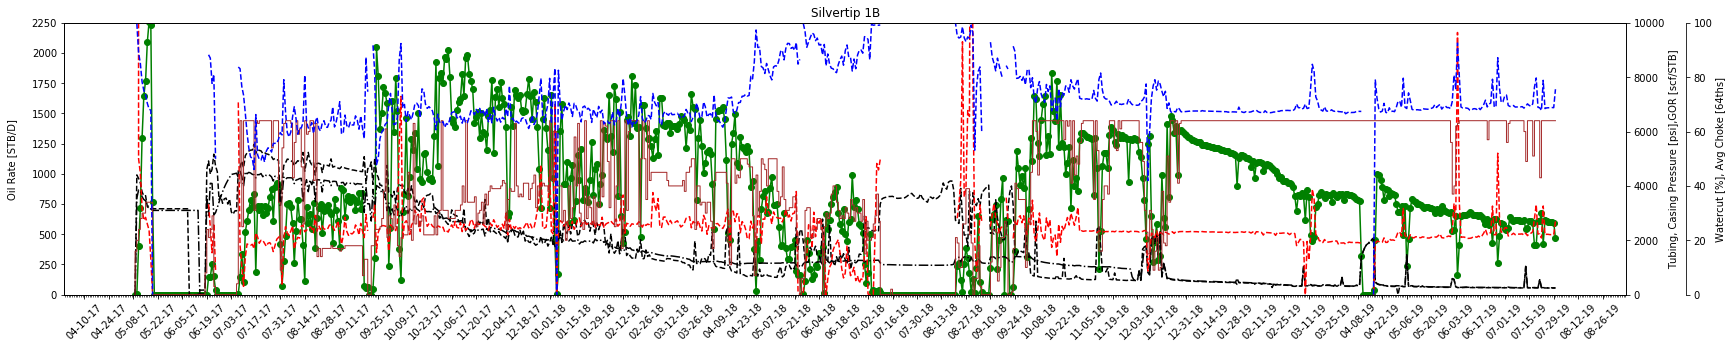

In [21]:

##Test Plotting
for i,well in enumerate(testdf):
    
    #import relevant datetime and plotting modules
    from datetime import datetime
    import matplotlib.dates as mdates
    from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
    import matplotlib.ticker as ticker
    
    #Plot Production Data
    fig, ax = plt.subplots(1, figsize=(28,5))
    ax.plot(testdf[i]['Date'], testdf[i]['Oil Rate'],marker='o', c='green', label='Oil Rate')
    #gor = ax.plot(listofwells[i]['Date'], (1000*listofwells[i]['GOR']),marker='o', c='red', label='GOR')
    ax.set_title("Silvertip " + testnames[i])
    ax.set_ylabel('Oil Rate [STB/D]')
    ax.yaxis.set_label_coords(-0.03,0.5)
    ax.set_ylim(bottom=0)
    ax.set_ylim(top=2200)
    plt.xticks(rotation=45)
    
    #Plot collection dates
    #ax1.axvline(conv('2013-05-14'), color='r', zorder=0)
    #datestoplot = CollectionDates[wellnames[i]]
    #datestoplot = ['2019-05-20','2019-03-05']
    #for date in datestoplot:
     #   ax.axvline(date,  linestyle='--',linewidth=.2,color='k', zorder=0)
    
    
    #Plot Pressures
    ax2 = ax.twinx()
    ax2.plot(testdf[i]['Date'], testdf[i]['Casing Pressure'], linestyle = '-.', c='black', label='Casing Pressure')
    ax2.plot(testdf[i]['Date'], testdf[i]['Tubing Pressure'], linestyle = '--', c='black', label='Tubing Pressure')
    gor2 = ax2.plot(testdf[i]['Date'], (1000*testdf[i]['GOR']),linestyle = '--', c='red', label='GOR')
    ax2.set_ylabel('Tubing, Casing Pressure [psi],GOR [scf/STB]')
    ax2.yaxis.set_label_position("right")
    ax2.set_ylim(bottom=0)
    ax2.set_ylim(top=10000)

        
    #Normalize Tick Intervals on Left Y axis
    y_min, y_max = ax.get_ylim()
    y2_min, y2_max = ax2.get_ylim()
    ticks = [(tick - y_min)/(y_max - y_min) for tick in ax.get_yticks()]
    ticks2 = [tick * y2_max for tick in ticks]
    ticks3 = [tick * y_max for tick in ticks]
    #ax2.set_yticks(ticks2)
    ax.set_yticks(ticks3)
    
    #Set axis parameters for second right axis
    par3 = ax.twinx()
    par3.spines['right'].set_position(('outward', 60))
    par3.yaxis.set_ticks_position('right')
    par3.set_ylabel('Watercut [%], Avg Choke [64ths]')
    par3.yaxis.set_label_position("right")
    
    #Plot Choke and Watercut Data
    choke = par3.step(testdf[i]['Date'], testdf[i]['Choke'],c='brown',linewidth = "1", label='Choke')
    wct = par3.plot(testdf[i]['Date'], (100*testdf[i]['Water Rate']/(testdf[i]['Oil Rate']+testdf[i]['Water Rate'])),\
                    linestyle = '--', c='blue',label='Water Cut')
    #gor2 = par3.plot(listofwells[i]['Date'], (10*listofwells[i]['GOR']),linestyle = '--', c='purple', label='GOR')
    #gor2 = par3.plot(listofwells[i]['Date'], (10*listofwells[i]['GOR']),linestyle = '--', c='red', label='GOR')
    #wor = par3.plot(listofwells[i]['Date'], (10*listofwells[i]['Water Rate']/listofwells[i]['Oil Rate']),linestyle = '--', c='blue', label='GOR')
    par3.set_ylim(bottom=0)
    par3.set_ylim(top=100)
    
    #Normalize Tick Intervals on Right Y axis
    y_ax2min, y_ax2max = ax2.get_ylim()
    ypar3_min, ypar3_max = par3.get_ylim()
    ticks_r = [(tick - ypar3_min)/(ypar3_max - ypar3_min) for tick in par3.get_yticks()]
    #ticks2_r = [tick * y2_max for tick in ticks]
    ticks3_r = [tick * y_ax2max for tick in ticks_r]
    
    #Normalize Tick Intervals on Right Y axis
    y_min, y_max = ax2.get_ylim()
    #y2_min, y2_max = par2.get_ylim()
    ticks = [(tick - y_min)/(y_max - y_min) for tick in ax.get_yticks()]
    ticks2 = [tick * y2_max for tick in ticks]
    ticks3 = [tick * y_max for tick in ticks]
   # par2.set_yticks(ticks2)
    ax.set_yticks(ticks3)
    
    #Add legends
    #fig.legend(bbox_to_anchor=(0.25, 0.28, 0.5, 0.5))
    #fig.legend(facecolor="white",markerscale=2,framealpha = 1,prop={'size': 24}, bbox_to_anchor=(0.25, 0.28, 0.5, 0.5))
    #ax.legend(loc='center right', bbox_to_anchor=(1, 0.5))
    
    #Reformat Date Series
    #Set tick marks intervals for x-axis, set minor ticks daily, major ticks weekly (every monday)
    days = mdates.DayLocator()
    months = mdates.MonthLocator()
    myFmt = mdates.DateFormatter("%m-%d-%y")
    biweekly = mdates. WeekdayLocator(byweekday=MO,interval = 2)
    #Assign ticks
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_locator(biweekly)
    ax.xaxis.set_major_formatter(myFmt)
    
    
    #print(testnames[i])
    #xs = gugu
    #print(xs)
    #xs = ProdData10['Unnamed: 0'][1:3]
    #axvlines(xs,ax,linestyle='--',c='k')
    #key = testnames[i]
    #xs = testdates[key]

    #Save Image
    imageloc = folderloc +'/' + testnames[i] +'.png'
    fig.savefig(imageloc, dpi=500, bbox_inches='tight')
        

In [24]:
#newdfs.head()

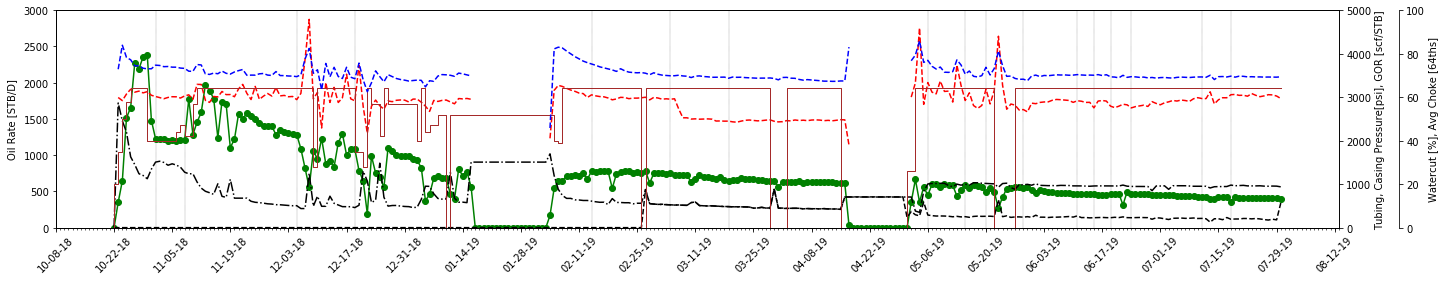

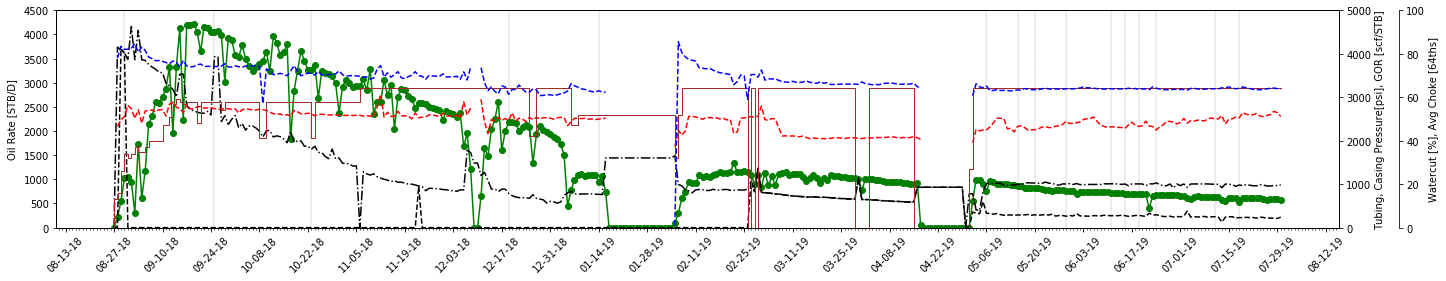

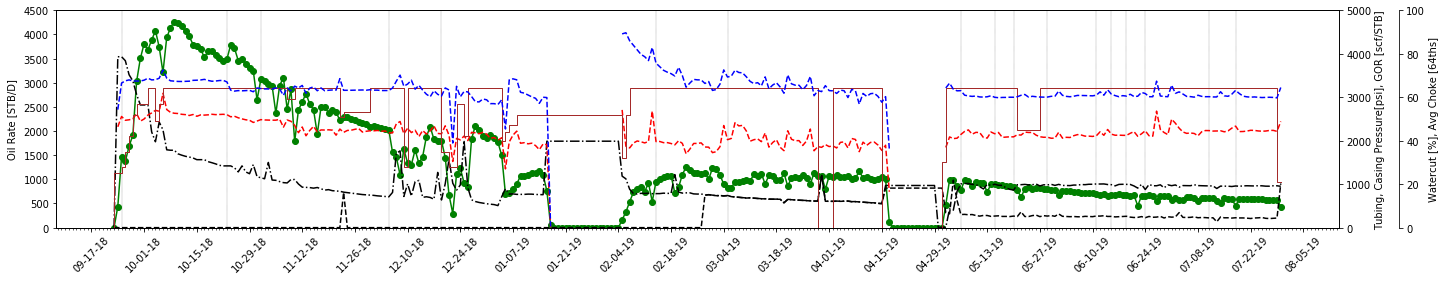

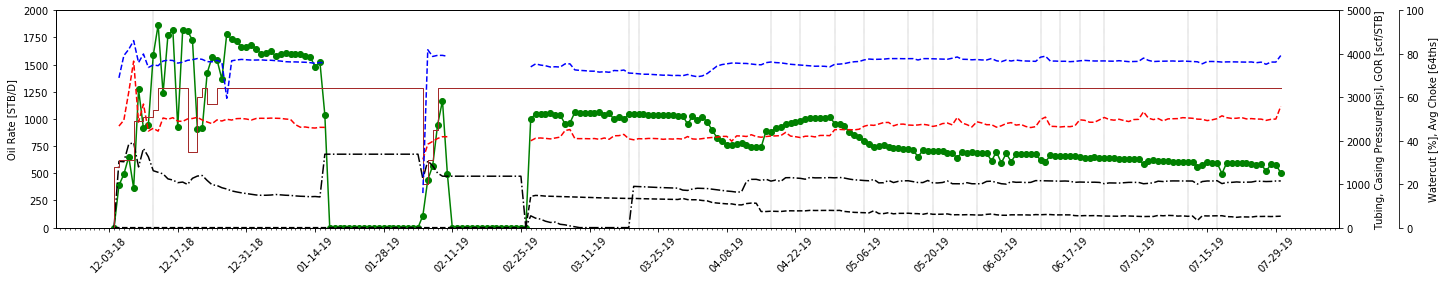

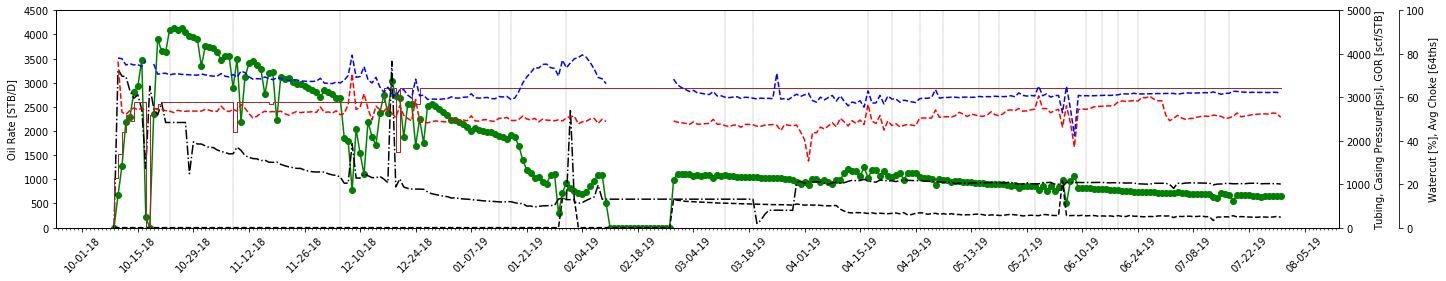

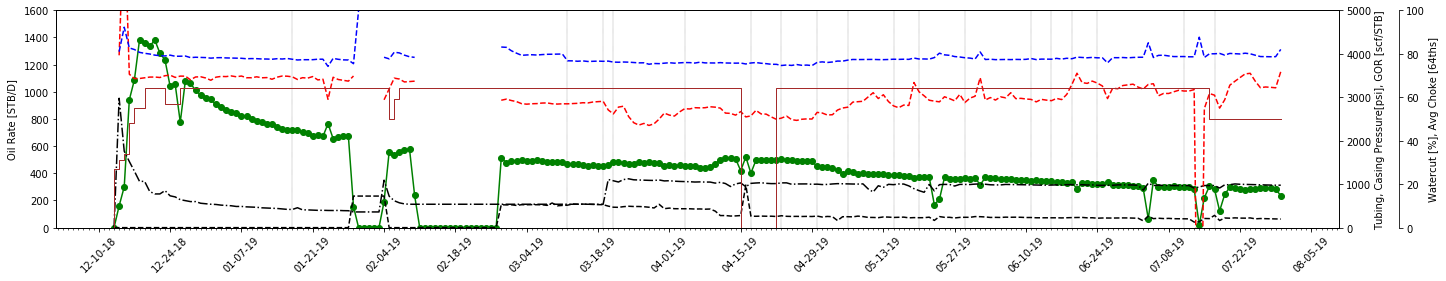

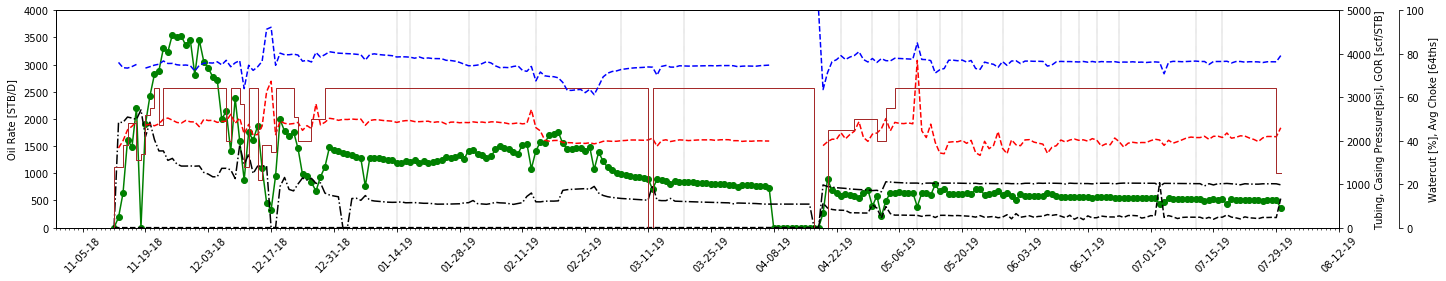

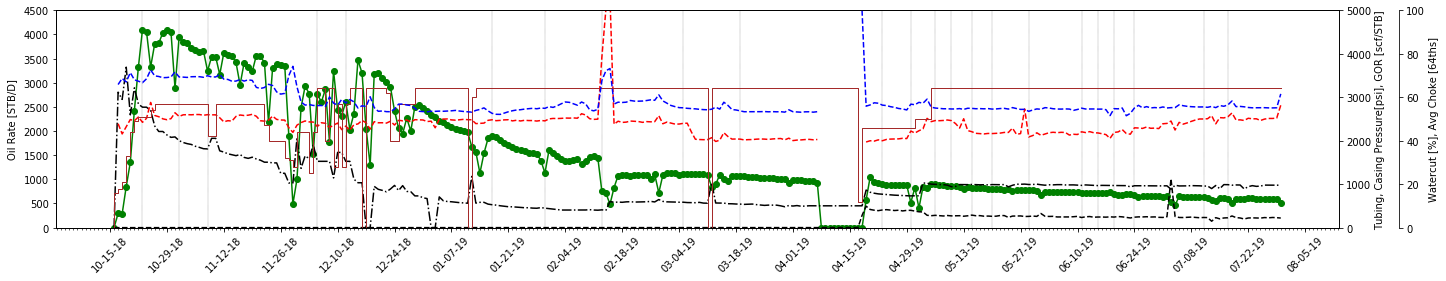

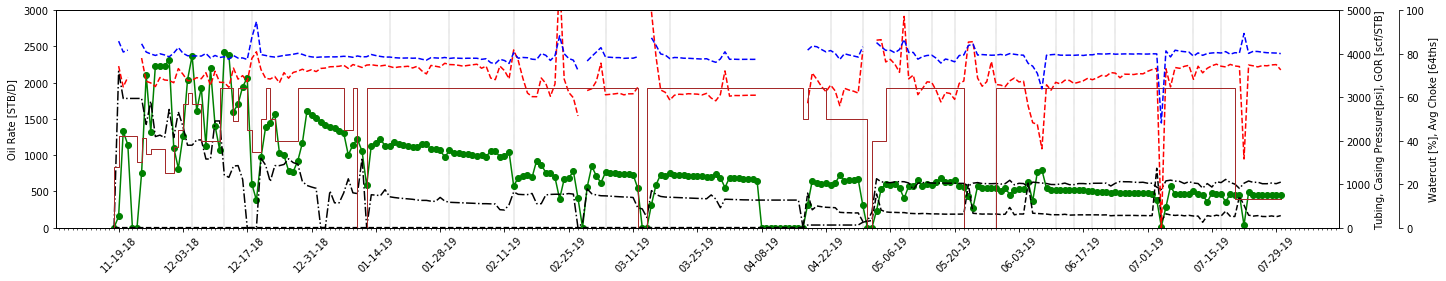

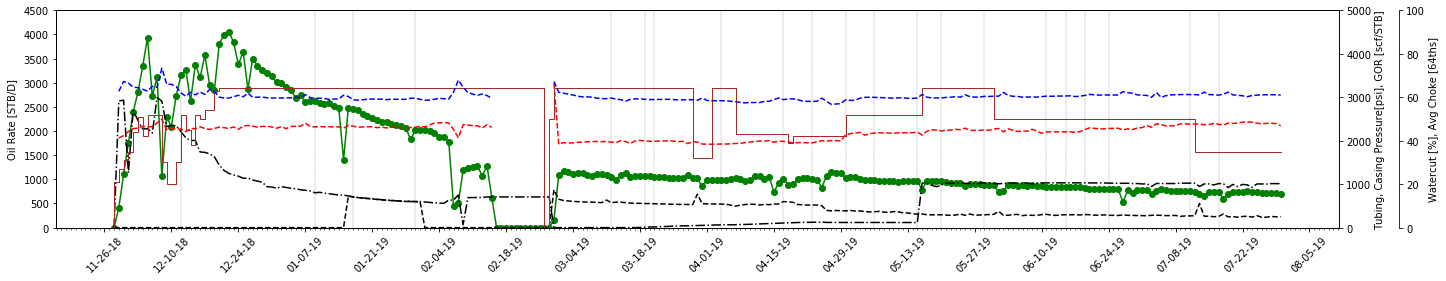

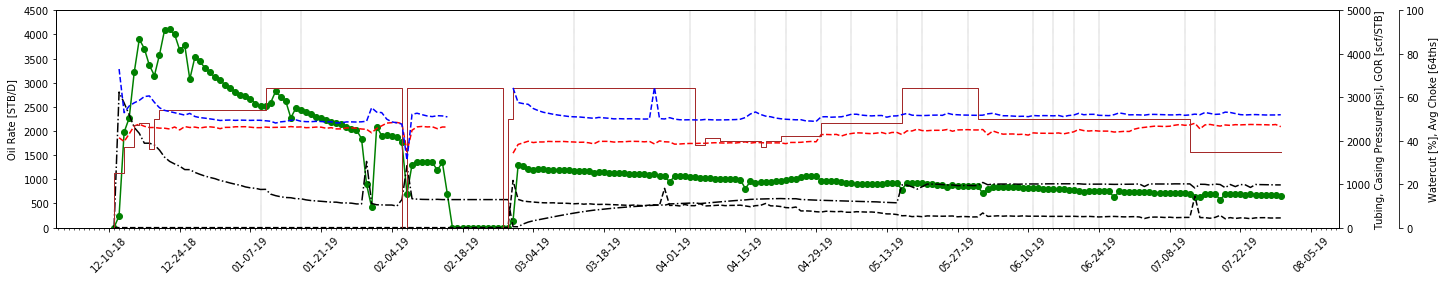

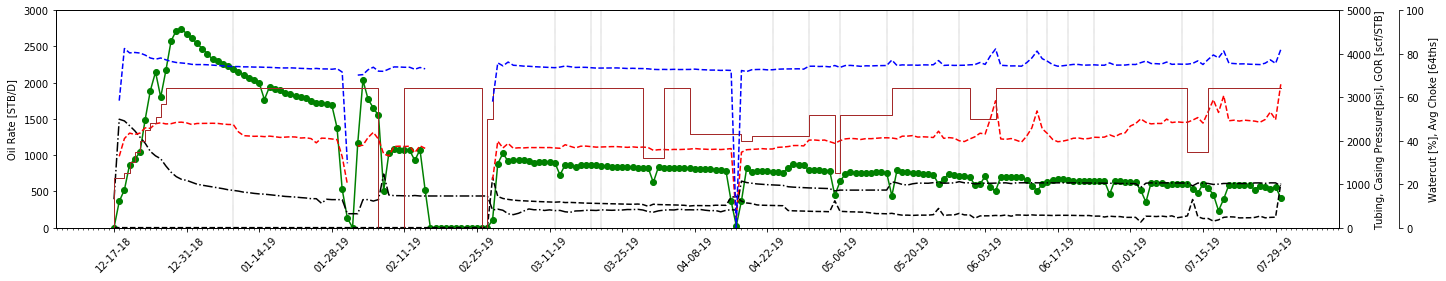

In [58]:
for i,well in enumerate(newdfs):
    
    #import relevant datetime and plotting modules
    from datetime import datetime
    import matplotlib.dates as mdates
    from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
    import matplotlib.ticker as ticker
    
    #Plot Production Data
    fig, ax = plt.subplots(1, figsize=(23,4))
    ax.plot(newdfs[well]['Date'], newdfs[well]['Oil Rate'],marker='o', c='green', label='Oil Rate')
    #gor = ax.plot(listofwells[i]['Date'], (1000*listofwells[i]['GOR']),marker='o', c='red', label='GOR')
    #ax.set_title("Silvertip " + wellnames[i] )
    ax.set_ylabel('Oil Rate [STB/D]')
    ax.yaxis.set_label_coords(-0.03,0.5)
    ax.set_ylim(bottom=0)
    plt.xticks(rotation=45)
    
    #Plot Collection dates
    datestoplot = CollectionDates[wellnames[i]]
    #datestoplot = ['2019-05-20','2019-03-05']
    for date in datestoplot:
        ax.axvline(date,  linestyle='--',linewidth=.2,color='k', zorder=0)

    
    #Plot Pressures
    ax2 = ax.twinx()
    ax2.plot(newdfs[well]['Date'], newdfs[well]['Casing Pressure'], linestyle = '-.', c='black', label='Casing Pressure')
    ax2.plot(newdfs[well]['Date'], newdfs[well]['Tubing Pressure'], linestyle = '--', c='black', label='Tubing Pressure')
    gor2 = ax2.plot(newdfs[well]['Date'], (1000*newdfs[well]['GOR']),linestyle = '--', c='red', label='GOR')
    ax2.set_ylabel('Tubing, Casing Pressure[psi], GOR [scf/STB]')
    ax2.yaxis.set_label_position("right")
    ax2.set_ylim(bottom=0)
    ax2.set_ylim(top=5000)
    #y_ax2min, y_ax2max = ax2.get_ylim()
    #ax2.set_ylim(top = y_ax2max*1.3)
        
    #Normalize Tick Intervals on Left Y axis
    y_min, y_max = ax.get_ylim()
    y2_min, y2_max = ax2.get_ylim()
    ticks = [(tick - y_min)/(y_max - y_min) for tick in ax.get_yticks()]
    ticks2 = [tick * y2_max for tick in ticks]
    ticks3 = [tick * y_max for tick in ticks]
    #ax2.set_yticks(ticks2)
    ax.set_yticks(ticks3)
    
    #Set axis parameters for second right axis
    par3 = ax.twinx()
    par3.spines['right'].set_position(('outward', 60))
    par3.yaxis.set_ticks_position('right')
    par3.set_ylabel('Watercut [%], Avg Choke [64ths]')
    par3.yaxis.set_label_position("right")
    
    #Plot Choke and Watercut Data
    choke = par3.step(newdfs[well]['Date'], newdfs[well]['Choke'],c='brown',linewidth = "1", label='Choke')
    wct = par3.plot(newdfs[well]['Date'], (100*newdfs[well]['Water Rate']/(newdfs[well]['Oil Rate']+newdfs[well]['Water Rate'])),\
                    linestyle = '--', c='blue',label='Water Cut')
    par3.set_ylim(bottom=0)
    par3.set_ylim(top=100)
    
    #Normalize Tick Intervals on Right Y axis
    y_ax2min, y_ax2max = ax2.get_ylim()
    ypar3_min, ypar3_max = par3.get_ylim()
    ticks_r = [(tick - ypar3_min)/(ypar3_max - ypar3_min) for tick in par3.get_yticks()]
    #ticks2_r = [tick * y2_max for tick in ticks]
    ticks3_r = [tick * y_ax2max for tick in ticks_r]
    
    #Normalize Tick Intervals on Right Y axis
    y_min, y_max = ax2.get_ylim()
    #y2_min, y2_max = par2.get_ylim()
    ticks = [(tick - y_min)/(y_max - y_min) for tick in ax.get_yticks()]
    ticks2 = [tick * y2_max for tick in ticks]
    ticks3 = [tick * y_max for tick in ticks]
   # par2.set_yticks(ticks2)
    ax.set_yticks(ticks3)
    
    #Add legends
    #fig.legend(bbox_to_anchor=(0.25, 0.28, 0.5, 0.5))
    
    #Reformat Date Series
    #Set tick marks intervals for x-axis, set minor ticks daily, major ticks weekly (every monday)
    days = mdates.DayLocator()
    months = mdates.MonthLocator()
    myFmt = mdates.DateFormatter("%m-%d-%y")
    biweekly = mdates. WeekdayLocator(byweekday=MO,interval = 2)
    #Assign ticks
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_locator(biweekly)
    ax.xaxis.set_major_formatter(myFmt)
    
    #xs = CollectionDates[well]
    #xs = ProdData10['Unnamed: 0'][1:3]
    #axvlines(xs,ax,linestyle='--',c='k')

    #Save Image
    imageloc = folderloc +'/' + wellnames[i] +'.png'
    fig.savefig(imageloc, dpi=500, bbox_inches='tight')
        

In [9]:
#Subplots for Final Presentation

#Define wells for comparison
Comparewells = [newdfs['2H'],newdfs['5H']]
Comparenames = 2
Colours = ["b","c"]

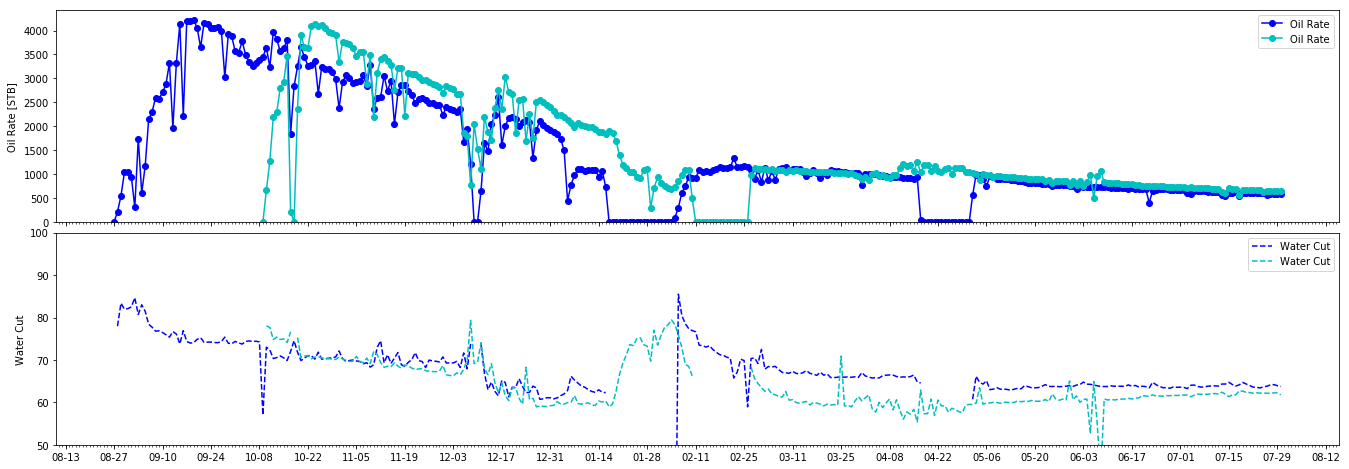

In [10]:
#Oil Rate Subplots for Final Presentation
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
    
#Plot Production Data
fig, axs = plt.subplots(2,sharex = True,figsize=(23,8))
fig.subplots_adjust( hspace = 0.05)
for i,well in enumerate(Comparewells):    
    axs[0].plot(Comparewells[i]['Date'], Comparewells[i]['Oil Rate'],marker='o', c=Colours[i], label='Oil Rate')
    #gor = ax.plot(listofwells[i]['Date'], (1000*listofwells[i]['GOR']),marker='o', c='red', label='GOR')
    #ax[0].set_title("Silvertip " + wellnames[i] )
    axs[0].set_ylabel('Oil Rate [STB]')
    axs[0].yaxis.set_label_coords(-0.03,0.5)
    axs[0].set_ylim(bottom=0)
    axs[0].legend()
    
   # ax[1].plot(Comparewells[i]['Date'], Comparewells[i]['Oil Rate'],marker='o', c=Colours[i], label='Oil Rate')
    #gor = ax.plot(listofwells[i]['Date'], (1000*listofwells[i]['GOR']),marker='o', c='red', label='GOR')
   # ax[1].set_title("Silvertip " + wellnames[i] )
    axs[1].set_ylabel('Water Cut')
    axs[1].set_ylim(top=100)
    axs[1].set_ylim(bottom=50)
    wct = axs[1].plot(Comparewells[i]['Date'], (100*Comparewells[i]['Water Rate']/(Comparewells[i]['Oil Rate']+Comparewells[i]['Water Rate'])),\
                linestyle = '--', c=Colours[i],label='Water Cut')
    axs[1].legend()
   # axs[1].axvline( x = 1, color='b')
    
    
#Reformat Date Series
#Set tick marks intervals for x-axis, set minor ticks daily, major ticks weekly (every monday)
days = mdates.DayLocator()
months = mdates.MonthLocator()
#weeks=mdates.WeeklyLocator()
myFmt = mdates.DateFormatter("%m-%d")
biweekly = mdates. WeekdayLocator(byweekday=MO,interval = 2)
#Assign ticks
axs[1].xaxis.set_minor_locator(days)
axs[1].xaxis.set_major_locator(biweekly)
axs[1].xaxis.set_major_formatter(myFmt)


In [42]:
#Define wells for comparison
Comparewells = [newdfs['1H'],newdfs['2H'],newdfs['3H'],newdfs['4H'],newdfs['5H']]
Comparenames = 5
Colours = ["lightseagreen","slategray","mediumorchid","darkcyan","steelblue"]
Compname = ['1H','2H','3H','4H','5H']
#plut

In [24]:
Comparewells[2].head()

,Date,BHP,BHP at gauge,Casing Pressure,Choke,Gas Rate,Injection Rate,Measured BHP,Measured BHT,Oil Rate,Tubing Pressure,Water Rate,GOR
0,2018-09-23,0.00,NaN,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2018-09-24,7750.10,NaN,3930.0,25.0,1011.00,0.0,0.0,0.0,436.0,0.0,518.0,2.318807
2,2018-09-25,7972.00,NaN,3930.0,25.0,3758.37,0.0,0.0,0.0,1470.0,0.0,2918.0,2.556714
3,2018-09-26,7947.05,NaN,3839.0,28.0,3397.12,0.0,0.0,0.0,1376.0,0.0,2860.0,2.468837
4,2018-09-27,7630.15,NaN,3515.0,35.0,4175.96,0.0,0.0,0.0,1684.0,0.0,3570.0,2.479786


In [44]:
fifi = Comparewells[2]['Date'] - Comparewells[2]['Date'].shift()

In [49]:
Comparewells[2]['Days Since IP'] = (Comparewells[2]['Date'] - Comparewells[2]['Date'].shift())

In [53]:
Comparewells[2]['Days Since IP Sum'] = range(len(Comparewells[2]))

In [63]:
#Comparewells[2]

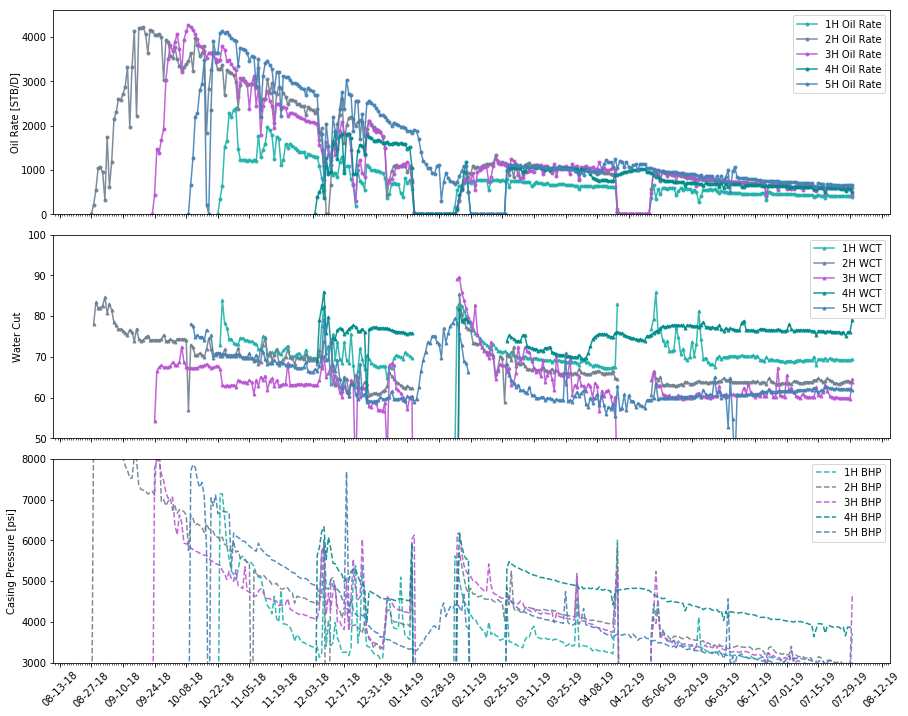

In [43]:
#Oil Rate, Casing Pressure Subplots for Final Presentation
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
    
#Plot Production Data
fig, axs = plt.subplots(3,sharex = True,figsize=(15,12))
fig.subplots_adjust( hspace = 0.1)
for i,well in enumerate(Comparewells):    
    axs[0].plot(Comparewells[i]['Date'], Comparewells[i]['Oil Rate'],marker='o', markersize = 3, alpha = 0.9, c=Colours[i], label= Compname[i] +' '+ 'Oil Rate')
    #gor = ax.plot(listofwells[i]['Date'], (1000*listofwells[i]['GOR']),marker='o', c='red', label='GOR')
    #ax[0].set_title("Silvertip " + wellnames[i] )
    axs[0].set_ylabel('Oil Rate [STB/D]')
    axs[0].yaxis.set_label_coords(-0.04,0.5)
    axs[0].set_ylim(bottom=0)
    axs[0].set_ylim(top=4600)
    axs[0].legend()
    
    axs[1].set_ylabel('Water Cut')
    axs[1].set_ylim(top=100)
    axs[1].set_ylim(bottom=50)
    wct = axs[1].plot(Comparewells[i]['Date'], (100*Comparewells[i]['Water Rate']/(Comparewells[i]['Oil Rate']+Comparewells[i]['Water Rate'])),\
                marker='^', markersize = 3,alpha = 0.9, c=Colours[i],label=Compname[i] +' '+'WCT')
                      #linestyle = '--', c=Colours[i],label=Compname[i] +''+'Water Cut')
    axs[1].legend()
    
    #Plot Pressures
    #axs[2] = ax.twinx()
    axs[2].plot(Comparewells[i]['Date'], Comparewells[i]['BHP'], linestyle = '--', c=Colours[i], alpha = 0.9,label=Compname[i] +' '+'BHP')
    #axs[2].plot(Comparewells[i]['Date'], Comparewells[i]['Casing Pressure'], linestyle = '-.', c=Colours[i], label=Compname[i] +' '+'CSG Pres.')
    #axs[2].plot(Comparewells[i]['Date'], Comparewells[i]['Tubing Pressure'], linestyle = '--', c=Colours[i], label=Compname[i] +''+'Tubing Pressure')
    #axs[2].set_ylabel('Tubing, Casing Pressure [psi]')
    axs[2].set_ylabel('Casing Pressure [psi]')
    axs[2].yaxis.set_label_position("left")
    axs[2].set_ylim(bottom=3000)
    axs[2].set_ylim(top=8000)
    #axs[2].legend(prop= {'size':6})
    axs[2].legend()
    
#Reformat Date Series
#Set tick marks intervals for x-axis, set minor ticks daily, major ticks weekly (every monday)
days = mdates.DayLocator()
months = mdates.MonthLocator()
#weeks=mdates.WeeklyLocator()
myFmt = mdates.DateFormatter("%m-%d-%y")
biweekly = mdates. WeekdayLocator(byweekday=MO,interval = 2)
#Assign ticks
axs[1].xaxis.set_minor_locator(days)
axs[1].xaxis.set_major_locator(biweekly)
axs[1].xaxis.set_major_formatter(myFmt)

plt.xticks(rotation=45)

#Save Image
imagename = 'OffsetFrac'
#imageloc = folderloc +'/' + imagename +'.png'
#imageloc = folderloc +'/' + imagename +'.png'
#fig.savefig(imageloc, dpi=500, bbox_inches='tight')
    

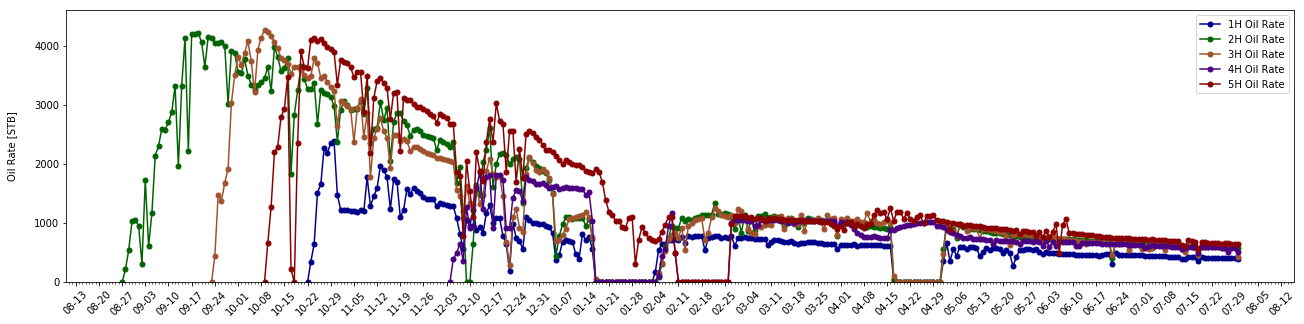

In [34]:
#Plot Production Data
fig, axs = plt.subplots(1,sharex = True,figsize=(22,5))
fig.subplots_adjust( hspace = 0.1)
for i,well in enumerate(Comparewells):    
    axs.plot(Comparewells[i]['Date'], Comparewells[i]['Oil Rate'],marker='o', markersize = 5, c=Colours[i], label= Compname[i] +' '+ 'Oil Rate')
    #gor = ax.plot(listofwells[i]['Date'], (1000*listofwells[i]['GOR']),marker='o', c='red', label='GOR')
    #ax[0].set_title("Silvertip " + wellnames[i] )
    axs.set_ylabel('Oil Rate [STB]')
    axs.yaxis.set_label_coords(-0.04,0.5)
    axs.set_ylim(bottom=0)
    axs.set_ylim(top=4600)
    axs.legend()
    
#Reformat Date Series
#Set tick marks intervals for x-axis, set minor ticks daily, major ticks weekly (every monday)
days = mdates.DayLocator()
months = mdates.MonthLocator()
#weeks=mdates.WeeklyLocator()
myFmt = mdates.DateFormatter("%m-%d")
biweekly = mdates. WeekdayLocator(byweekday=MO,interval = 2)
weekly = mdates. WeekdayLocator(byweekday=MO,interval = 1)
#Assign ticks
axs.xaxis.set_minor_locator(days)
axs.xaxis.set_major_locator(weekly)
axs.xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=45)

#Save Image
imagename = 'Oil Rate'
#imageloc = folderloc +'/' + imagename +'.png'
imageloc = folderloc +'/' + imagename +'.png'
fig.savefig(imageloc, dpi=500, bbox_inches='tight')

In [35]:
#Define wells for comparison
Comparewells = [newdfs['1H'],newdfs['2H'],newdfs['3H'],newdfs['5H'],newdfs['8H']]
Comparenames = 5
Colours = ["darkblue","darkgreen","sienna","indigo","darkred"]
Compname = ['1H','2H','3H','5H','8H']

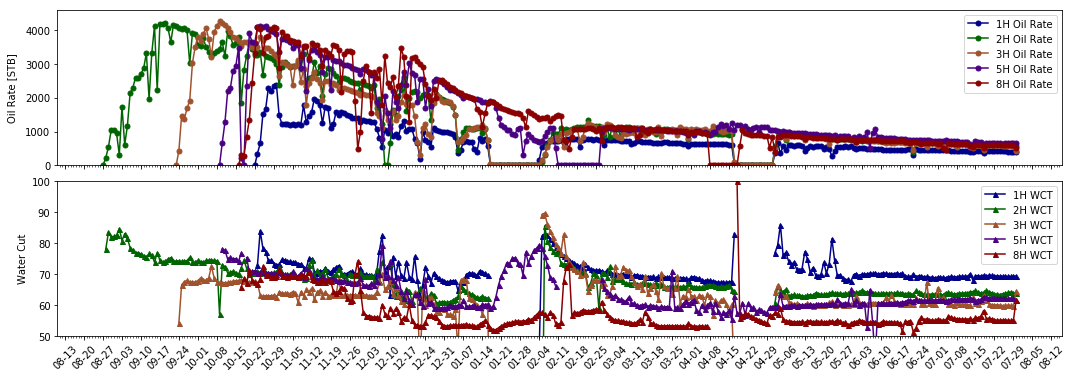

In [38]:
#Oil Rate, watercut Subplots for Final Presentation
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
    
#Plot Production Data
fig, axs = plt.subplots(2,sharex = True,figsize=(18,6))
fig.subplots_adjust( hspace = 0.1)
for i,well in enumerate(Comparewells):    
    axs[0].plot(Comparewells[i]['Date'], Comparewells[i]['Oil Rate'],marker='o', markersize = 5, c=Colours[i], label= Compname[i] +' '+ 'Oil Rate')
    #gor = ax.plot(listofwells[i]['Date'], (1000*listofwells[i]['GOR']),marker='o', c='red', label='GOR')
    #ax[0].set_title("Silvertip " + wellnames[i] )
    axs[0].set_ylabel('Oil Rate [STB]')
    axs[0].yaxis.set_label_coords(-0.04,0.5)
    axs[0].set_ylim(bottom=0)
    axs[0].set_ylim(top=4600)
    axs[0].legend()
    
    axs[1].set_ylabel('Water Cut')
    axs[1].set_ylim(top=100)
    axs[1].set_ylim(bottom=50)
    wct = axs[1].plot(Comparewells[i]['Date'], (100*Comparewells[i]['Water Rate']/(Comparewells[i]['Oil Rate']+Comparewells[i]['Water Rate'])),\
                marker='^', markersize = 5, c=Colours[i],label=Compname[i] +' '+'WCT')
                      #linestyle = '--', c=Colours[i],label=Compname[i] +''+'Water Cut')
    axs[1].legend()
    
    
#Reformat Date Series
#Set tick marks intervals for x-axis, set minor ticks daily, major ticks weekly (every monday)
days = mdates.DayLocator()
months = mdates.MonthLocator()
#weeks=mdates.WeeklyLocator()
myFmt = mdates.DateFormatter("%m-%d")
biweekly = mdates. WeekdayLocator(byweekday=MO,interval = 2)
weekly = mdates. WeekdayLocator(byweekday=MO,interval = 1)
#Assign ticks
axs[1].xaxis.set_minor_locator(days)
axs[1].xaxis.set_major_locator(weekly)
axs[1].xaxis.set_major_formatter(myFmt)

plt.xticks(rotation=45)

#Save Image
imagename = 'Oil Rate Water Cut'
#imageloc = folderloc +'/' + imagename +'.png'
imageloc = folderloc +'/' + imagename +'.png'
fig.savefig(imageloc, dpi=500, bbox_inches='tight')
    

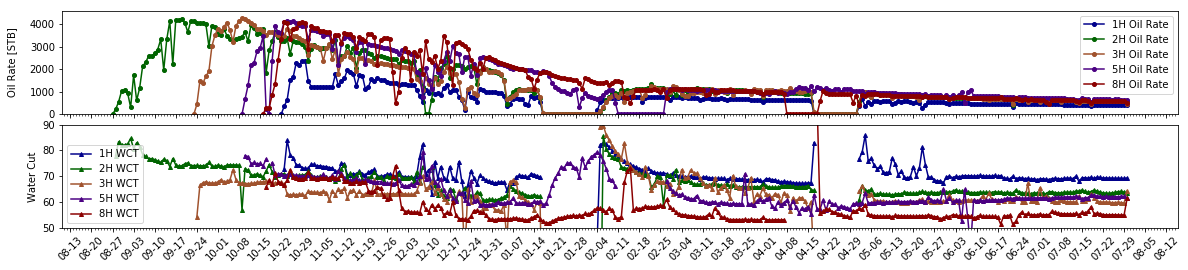

In [44]:
#different aspect ratio
fig, axs = plt.subplots(2,sharex = True,figsize=(20,4))
fig.subplots_adjust( hspace = 0.1)
for i,well in enumerate(Comparewells):    
    axs[0].plot(Comparewells[i]['Date'], Comparewells[i]['Oil Rate'],marker='o', markersize = 4, c=Colours[i], label= Compname[i] +' '+ 'Oil Rate')
    #gor = ax.plot(listofwells[i]['Date'], (1000*listofwells[i]['GOR']),marker='o', c='red', label='GOR')
    #ax[0].set_title("Silvertip " + wellnames[i] )
    axs[0].set_ylabel('Oil Rate [STB]')
    axs[0].yaxis.set_label_coords(-0.04,0.5)
    axs[0].set_ylim(bottom=0)
    axs[0].set_ylim(top=4600)
    axs[0].legend()
    
    axs[1].set_ylabel('Water Cut')
    axs[1].set_ylim(top=90)
    axs[1].set_ylim(bottom=50)
    wct = axs[1].plot(Comparewells[i]['Date'], (100*Comparewells[i]['Water Rate']/(Comparewells[i]['Oil Rate']+Comparewells[i]['Water Rate'])),\
                marker='^', markersize = 4, c=Colours[i],label=Compname[i] +' '+'WCT')
                      #linestyle = '--', c=Colours[i],label=Compname[i] +''+'Water Cut')
    axs[1].legend()
    
    
#Reformat Date Series
#Set tick marks intervals for x-axis, set minor ticks daily, major ticks weekly (every monday)
days = mdates.DayLocator()
months = mdates.MonthLocator()
#weeks=mdates.WeeklyLocator()
myFmt = mdates.DateFormatter("%m-%d")
biweekly = mdates. WeekdayLocator(byweekday=MO,interval = 2)
weekly = mdates. WeekdayLocator(byweekday=MO,interval = 1)
#Assign ticks
axs[1].xaxis.set_minor_locator(days)
axs[1].xaxis.set_major_locator(weekly)
axs[1].xaxis.set_major_formatter(myFmt)

plt.xticks(rotation=45)

#Save Image
imagename = 'Oil Rate Water Cut Shorter'
#imageloc = folderloc +'/' + imagename +'.png'
imageloc = folderloc +'/' + imagename +'.png'
fig.savefig(imageloc, dpi=500, bbox_inches='tight')

In [ ]:
#Define wells for comparison
Comparewells = [newdfs['1H'],newdfs['2H'],newdfs['3H'],newdfs['4H'],newdfs['5H']]
Comparenames = 5
Colours = ["darkblue","darkgreen","sienna","indigo","darkred"]
Compname = ['1H','2H','3H','4H','5H']

In [ ]:
Colours = ["lightseagreen","slategray","mediumorchid","darkcyan","steelblue"]

In [64]:
import pylab
NUM_COLORS = 13

cm = pylab.get_cmap('gist_rainbow')
for i in range(NUM_COLORS):
    color = cm(1.*i/NUM_COLORS) 

In [65]:
color

(0.8450554134697361, 0.0, 1.0, 1.0)

In [84]:
#Change 0's to nan
def zero_to_nan(sample):
    return [np.nan if x==0 else x for x in sample]

szdfs = {}
for well in newdfs:
    szdfs[well] = newdfs[well].copy()
    szdfs[well]['Oil Rate'] = zero_to_nan(szdfs[well]['Oil Rate'])

In [110]:
#szdfs['1H']

In [ ]:
newdfs = 

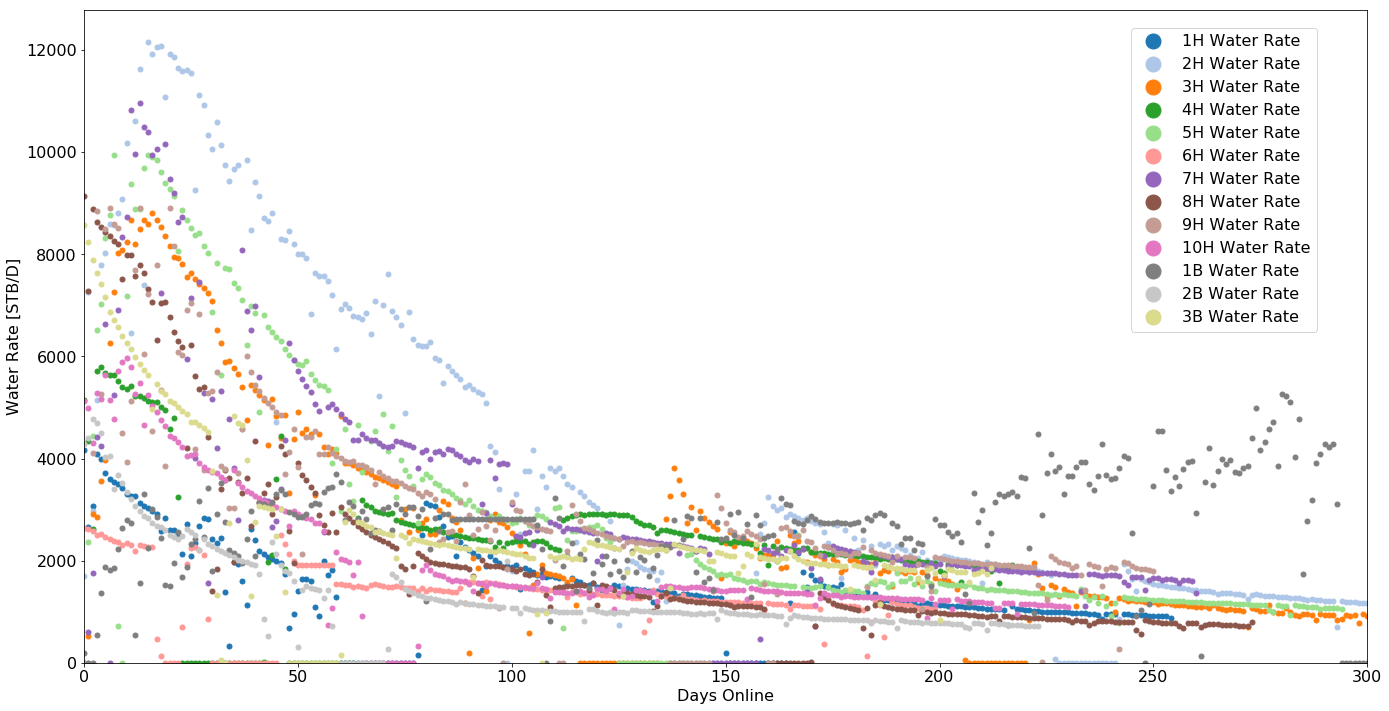

In [109]:
#import relevant datetime and plotting modules
import matplotlib.ticker as ticker
import pylab
NUM_COLORS = 14
cm = pylab.get_cmap('tab20')

#Plot Production Data
fig, ax = plt.subplots(1, figsize=(23,12))
for i,well in enumerate(newdfs):
    
    wellcolor = cm(1.*i/NUM_COLORS)
    ax.plot(newdfs[well]['DaysOn'], newdfs[well]['Water Rate'],marker='o', markersize = 5, alpha = 1, \
            linewidth=0, c=wellcolor, label = wellnames[i] + ' '+ 'Water Rate')
    
    #wellcolor = cm(1.*i/NUM_COLORS)
    #ax.plot(newdfs[well]['DaysOn'], newdfs[well]['Oil Rate'],marker='o', markersize = 5, alpha = 1, \
    #        linewidth=0, c=wellcolor, label = wellnames[i] + ' '+ 'Oil Rate')
    
#Add legends
fig.legend(bbox_to_anchor=(0.25, 0.28, 0.55, 0.52),markerscale=3, fontsize = 16)
#ax.set_ylabel('Oil Rate [STB/D]',fontsize = 16)
ax.set_ylabel('Water Rate [STB/D]',fontsize = 16)
ax.set_xlabel('Days Online', fontsize = 16)
#ax.yaxis.set_label_coords(-0.03,0.5)
ax.set_ylim(bottom=0)
#ax.set_ylim(top=8000)
#ax.set_ylim(top=4500)
ax.set_xlim([0,300])
ax.tick_params(axis="both", labelsize=16)

#Save Image
#imageloc = folderloc +'/' + 'Silvertip Oil Rate'+'.png'
imageloc = folderloc +'/' + 'Silvertip Water Rate'+'.png'
fig.savefig(imageloc, dpi=1000, bbox_inches='tight')
        

In [10]:
#Create Directory for Image Save
dirpath = os.getcwd()
folderlocCSVs = dirpath + '/SavedCSVs/'
PlotlocCSVs = dirpath + '/Images/SavedPlots'

try:  
     os.makedirs(PlotlocCSVs)
except OSError:  
     print ("Creation of the directory %s failed" % PlotlocCSVs)
else:  
        print ("Successfully created the directory %s" % PlotlocCSVs)
            

Creation of the directory /home/jovyan/APC local/Final Presentation/Images/SavedPlots failed


In [11]:
PlotlocCSVs

'/home/jovyan/APC local/Final Presentation/Images/SavedPlots'

In [23]:
# Save DFs as CSV

#save location
saveloc = folderlocCSVs 
for i,well in enumerate (newdfs):
    path = saveloc + wellnames[i] + '.csv'
    print(path)
    newdfs[well].to_csv(path)

NameError: name 'folderlocCSVs' is not defined

In [1]:
newdfs['3B'].head()

NameError: name 'newdfs' is not defined

In [15]:
#Define wells for comparison
#All Beta
#Comparewells = [newdfs['2H'],newdfs['3H'],newdfs['5H'],newdfs['8H'],newdfs['10H'],\
#                newdfs['2B']]
#Compname = ['2H','3H','5H','8H','10H','2B']

#Upper Alpha
#Comparewells = [newdfs['4H'],newdfs['3B']]
#Compname = ['4H','3B']

#Upper Delta:
#Comparewells = [newdfs['1H'],newdfs['6H'],newdfs['9H']]
#Compname = ['1H','6H','9H']

#Comparenames = 5
#Colours = ["darkblue","darkgreen","sienna","indigo","darkred"]


#Compname = ['4H','3B']
            #''2H','3H','5H','8H']
    
    
#Upper Beta
Comparewells = [newdfs['3H'],newdfs['5H'],newdfs['10H']]
Compname = ['3H','5H','10H']

#Middle Beta
#Comparewells = [newdfs['2H'],newdfs['8H'],newdfs['2B']]
#Compname = ['2H','8H','B2 H']

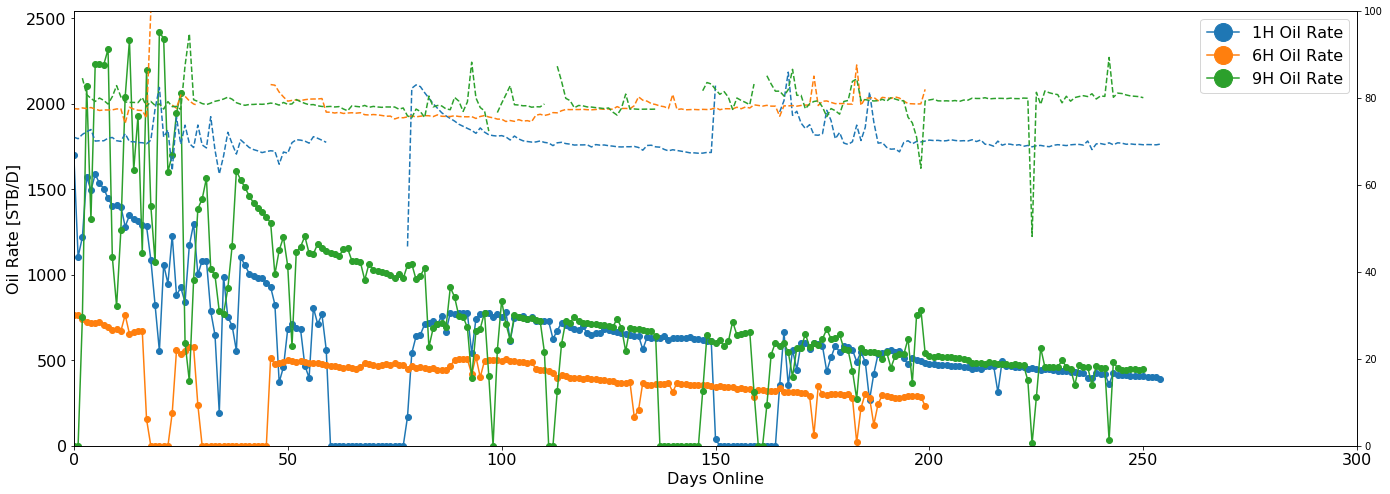

In [149]:
#import relevant datetime and plotting modules
import matplotlib.ticker as ticker
import pylab
NUM_COLORS = 8
cm = pylab.get_cmap('tab10')
#cm = pylab.get_cmap('tab20')

#Plot Production Data
fig, ax = plt.subplots(1, figsize=(23,8))
ax2 = ax.twinx()
for i,well in enumerate(Comparewells):
    
    wellcolor = cm(1.*i/NUM_COLORS)
    ax.plot(Comparewells[i]['DaysOn'], Comparewells[i]['Oil Rate'],marker='o', markersize = 6, alpha = 1, \
            #linewidth=0, \
            c=wellcolor, label = Compname[i] + ' '+ 'Oil Rate')
    wct = ax2.plot(Comparewells[i]['DaysOn'], (100*Comparewells[i]['Water Rate']/(Comparewells[i]['Oil Rate']+Comparewells[i]['Water Rate'])),\
                    linestyle = '--', c=wellcolor ,label=Compname[i] + ' '+'Water Cut')
    #wellcolor = cm(1.*i/NUM_COLORS)
    #ax.plot(newdfs[well]['DaysOn'], newdfs[well]['Oil Rate'],marker='o', markersize = 5, alpha = 1, \
    #        linewidth=0, c=wellcolor, label = wellnames[i] + ' '+ 'Oil Rate')
    
#Add legends
#fig.legend(bbox_to_anchor=(0.25, 0.28, 0.55, 0.52),markerscale=3, fontsize = 16)
#ax.set_ylabel('Oil Rate [STB/D]',fontsize = 16)
ax.set_ylabel('Oil Rate [STB/D]',fontsize = 16)
ax.set_xlabel('Days Online', fontsize = 16)
#ax.yaxis.set_label_coords(-0.03,0.5)
ax.set_ylim(bottom=0)
#ax.set_ylim(top=8000)
#ax.set_ylim(top=4500)
ax.set_xlim([0,300])
ax2.set_ylim([0,100])
ax.tick_params(axis="both", labelsize=16)
ax.legend(bbox_to_anchor=(0.25, 0.28, 0.75, 0.72),markerscale=3, fontsize = 16)
#Save Image
#imageloc = folderloc +'/' + 'Silvertip Oil Rate'+'.png'
#imageloc = folderloc +'/' + 'Silvertip Oil Rate WCT Delta'+'.png'
imageloc = folderloc +'/' + 'Silvertip Oil Rate WCT Delta'+'.png'
fig.savefig(imageloc, dpi=1000, bbox_inches='tight')
        

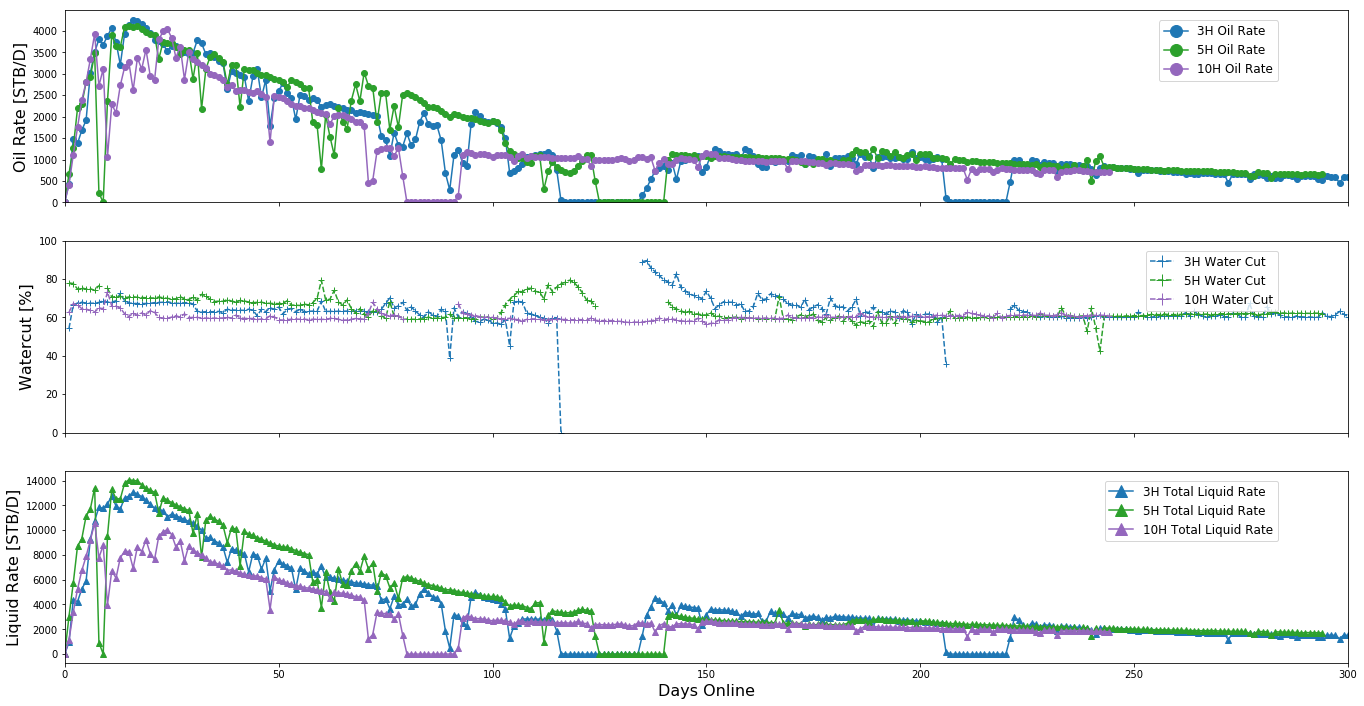

In [16]:
#import relevant datetime and plotting modules
import matplotlib
import pylab
NUM_COLORS = 5
cm = pylab.get_cmap('tab10')
#cm = pylab.get_cmap('tab20')

#Plot Production Data
fig, axs = plt.subplots(3, sharex = True, figsize=(23,12))
#ax2 = ax.twinx()
for i,well in enumerate(Comparewells):
    
    wellcolor = cm(1.*i/NUM_COLORS)
    axs[0].plot(Comparewells[i]['DaysOn'], Comparewells[i]['Oil Rate'],marker='o', markersize = 6, alpha = 1, \
            #linewidth=0, \
            c=wellcolor, label = Compname[i] + ' '+ 'Oil Rate')
    axs[1].plot(Comparewells[i]['DaysOn'], (100*Comparewells[i]['Water Rate']/(Comparewells[i]['Oil Rate']+Comparewells[i]['Water Rate'])),\
                   marker='+', linestyle = '--', c=wellcolor ,label=Compname[i] + ' '+'Water Cut')
    
    axs[2].plot(Comparewells[i]['DaysOn'], (Comparewells[i]['Oil Rate']+Comparewells[i]['Water Rate']),\
                                            marker='^', markersize = 6, alpha = 1, \
            c=wellcolor, label = Compname[i] + ' '+ 'Total Liquid Rate')
    #axs[i].legend(bbox_to_anchor=(0.25, 0.28, 0.75, 0.72),markerscale=3, fontsize = 16)
    #axs[i].tick_params(axis="both", labelsize=16)
    #wellcolor = cm(1.*i/NUM_COLORS)
    #ax.plot(newdfs[well]['DaysOn'], newdfs[well]['Oil Rate'],marker='o', markersize = 5, alpha = 1, \
    #        linewidth=0, c=wellcolor, label = wellnames[i] + ' '+ 'Oil Rate')
    
#Add legends
#fig.legend(bbox_to_anchor=(0.25, 0.28, 0.55, 0.52),markerscale=3, fontsize = 16)
#ax.set_ylabel('Oil Rate [STB/D]',fontsize = 16)
axs[0].set_ylabel('Oil Rate [STB/D]',fontsize = 16)
axs[0].set_ylim(bottom=0)
axs[0].set_xlim([0,300])
axs[2].set_xlabel('Days Online', fontsize = 16)
#ax.yaxis.set_label_coords(-0.03,0.5)
axs[1].set_ylabel('Watercut [%]',fontsize = 16)
axs[2].set_ylabel('Liquid Rate [STB/D]',fontsize = 16)
#ax.set_ylim(top=8000)
#ax.set_ylim(top=4500)

axs[1].set_ylim([0,100])

for idx in range(3):
    axs[idx].legend(bbox_to_anchor=(0.25, 0.28, 0.70, 0.70),markerscale=2, fontsize = 12)
#axs.tick_params(axis="both", labelsize=16)
#axs[0].legend(bbox_to_anchor=(0.25, 0.28, 0.75, 0.72),markerscale=3, fontsize = 16)
#Save Image
#imageloc = folderloc +'/' + 'Silvertip Oil Rate'+'.png'
#imageloc = PlotlocCSVs +'/' + 'Silvertip composite plot AlphaLZs'+'.png'
imageloc = PlotlocCSVs +'/' + 'Silvertip composite plot UpperBetaLZs'+'.png'
fig.savefig(imageloc, dpi=200, bbox_inches='tight')
        

In [20]:
PlotlocCSVs

'/home/jovyan/APC local/Final Presentation/Images/SavedPlots'